In [79]:
import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path, PosixPath
import matplotlib.pyplot as plt

In [80]:
workdir = os.path.dirname(os.getcwd())
input_dir = Path(f"{workdir}/5_module_evaluation/data/")
pathway_path = os.path.join(input_dir, "HSV_disease_specific_pathways.csv")
module_path = Path("/home/bbc8731/HSV/3_module_expansion/data/categories_methods")
ppi_path = "/home/bbc8731/diseasemodulediscovery/tests/uniprot_ppi.csv"
plot_dir = "/home/bbc8731/HSV/5_module_evaluation/data/plot"


In [81]:
# read genes in the hsv pathway
hsv_pathway = pd.read_csv(pathway_path)
genes = hsv_pathway.loc[0, 'genes']
pathway_genes = set(genes.split(';'))

In [82]:
ppi = pd.read_csv(ppi_path, sep=None, engine="python", header=None)
all_proteins = set(ppi.iloc[:, 0]) | set(ppi.iloc[:, 1])

In [83]:
def compute_metrics(module_genes, pathway_genes, universe):
    universe = set(universe)

    module_genes = set(module_genes) & universe
    pathway_genes = set(pathway_genes) & universe

    overlap = module_genes & pathway_genes

    sensitivity = len(overlap) / len(pathway_genes) if len(pathway_genes) > 0 else 0
    precision = len(overlap) / len(module_genes) if len(module_genes) > 0 else 0

    return {
        "TP": len(overlap),
        "sensitivity": sensitivity,
        "precision": precision,
    }

In [84]:
# compute sensitivity/precision for all modules and all cutoffs, then save
module_files = sorted(module_path.rglob("*/consensus/uniprot_ppi.tsv"))
# thresholds = [1, 2, 3, 4, 5, 6]
thresholds = [4, 5, 6]

rows = []
for p in module_files:
    modules = pd.read_csv(p, sep=None, engine='python', comment='#')

    for cutoff in thresholds:
        filtered = modules.loc[modules['n_methods'] >= cutoff, :]
        module_genes = filtered['gene'].dropna().astype(str)
        module_size = len(module_genes)


        res = compute_metrics(module_genes, pathway_genes, all_proteins)
        rows.append({
            'category': p.parents[1].name,
            'cutoff': cutoff,
            'module_size': module_size,
            'TP': res['TP'],
            'sensitivity': res['sensitivity'],
            'precision': res['precision'],
        })

results_df = pd.DataFrame(rows).sort_values(['cutoff', 'category']).reset_index(drop=True)
out_path = input_dir / 'HSV_sensitivity_precision_all_modules_thresholds.csv'
results_df.to_csv(out_path, index=False)

print(f"Saved: {out_path}")
print(f"Rows: {len(results_df)}")
results_df.head(20)


Saved: /home/bbc8731/HSV/5_module_evaluation/data/HSV_sensitivity_precision_all_modules_thresholds.csv
Rows: 30


,category,cutoff,module_size,TP,sensitivity,precision
0,BP_Assembly_and_Packaging,4,48,6,0.033708,0.125000
1,BP_Egress_and_Envelopment,4,217,8,0.044944,0.036866
2,BP_Entry_and_Uncoating,4,70,5,0.028090,0.071429
3,BP_Immune_Evasion,4,138,7,0.039326,0.050725
4,BP_Replication_and_Transcription,4,152,11,0.061798,0.072368
5,BP_Uncharacterized,4,27,0,0.000000,0.000000
6,CC_Host_Cytoplasm,4,45,2,0.011236,0.044444
7,CC_Host_Membrane,4,214,10,0.056180,0.046729
8,CC_Host_Nucleus,4,249,20,0.112360,0.080321
9,CC_Virion_Components,4,56,5,0.028090,0.089286


In [85]:
# optional: quick summary (best per cutoff)
summary = []
for cutoff, grp in results_df.groupby('cutoff'):
    best_s = grp.sort_values('sensitivity', ascending=False).iloc[0]
    best_p = grp.sort_values('precision', ascending=False).iloc[0]
    summary.append({
        'cutoff': cutoff,
        'best_sensitivity_module': best_s['category'],
        'best_sensitivity': best_s['sensitivity'],
        'best_precision_module': best_p['category'],
        'best_precision': best_p['precision'],
    })

summary_df = pd.DataFrame(summary).sort_values('cutoff').reset_index(drop=True)
summary_out = input_dir / 'HSV_sensitivity_precision_summary_by_cutoff.csv'
summary_df.to_csv(summary_out, index=False)
print(f"Saved: {summary_out}")
summary_df


Saved: /home/bbc8731/HSV/5_module_evaluation/data/HSV_sensitivity_precision_summary_by_cutoff.csv


,cutoff,best_sensitivity_module,best_sensitivity,best_precision_module,best_precision
0,4,CC_Host_Nucleus,0.112360,BP_Assembly_and_Packaging,0.125000
1,5,CC_Host_Nucleus,0.112360,BP_Assembly_and_Packaging,0.119048
2,6,CC_Host_Nucleus,0.061798,BP_Assembly_and_Packaging,0.227273


In [86]:

plot_df = results_df.copy()

categories = sorted(plot_df['category'].unique())
cutoffs = sorted(plot_df['cutoff'].unique())

cat_to_y = {cat: i for i, cat in enumerate(categories)}
cut_to_x = {cut: i for i, cut in enumerate(cutoffs)}

plot_df['x'] = plot_df['cutoff'].map(cut_to_x)
plot_df['y'] = plot_df['category'].map(cat_to_y)

# --- Scale module size ---
max_size = plot_df['module_size'].max()
plot_df['size_scaled'] = (plot_df['module_size'] / max_size) * 1800

# --- Create figure ---
fig, axes = plt.subplots(
    1, 2,
    figsize=(11, 7),
    sharey=True
)

# ---------------- Sensitivity ----------------
sc1 = axes[0].scatter(
    plot_df['x'],
    plot_df['y'],
    s=plot_df['size_scaled'],
    c=plot_df['sensitivity'],
    cmap='Blues',
    vmin=plot_df['sensitivity'].min(),
    vmax=plot_df['sensitivity'].max(),
    edgecolors='black',
    linewidth=1.2,
    alpha=0.9
)

axes[0].set_xticks(range(len(cutoffs)))
axes[0].set_xticklabels(cutoffs, fontsize=9)
axes[0].set_yticks(range(len(categories)))
axes[0].set_yticklabels(categories, fontsize=11)
axes[0].set_xlabel("n_methods cutoff (>)", fontsize=10)
axes[0].set_title("Sensitivity")

axes[0].set_xlim(-0.5, len(cutoffs) - 0.5)
axes[0].set_ylim(-0.5, len(categories) - 0.5)
axes[0].invert_yaxis()

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label("Sensitivity")


# ---------------- Precision ----------------
sc2 = axes[1].scatter(
    plot_df['x'],
    plot_df['y'],
    s=plot_df['size_scaled'],
    c=plot_df['precision'],
    cmap='Blues',
    vmin=plot_df['precision'].min(),
    vmax=plot_df['precision'].max(),
    edgecolors='black',
    linewidth=1.2,
    alpha=0.9
)

axes[1].set_xticks(range(len(cutoffs)))
axes[1].set_xticklabels(cutoffs, fontsize=9)
axes[1].set_xlabel("n_methods cutoff (>)", fontsize=10)
axes[1].set_title("Precision")

axes[1].set_xlim(-0.5, len(cutoffs) - 0.5)
axes[1].set_ylim(-0.5, len(categories) - 0.5)
axes[1].invert_yaxis()

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Precision")


# ---------------- Module Size Legend (below figure) ----------------
# ---------------- Module Size Legend (right side with spacing) ----------------
size_values = np.linspace(
    plot_df['module_size'].min(),
    plot_df['module_size'].max(),
    6
).astype(int)

size_handles = [
    plt.scatter([], [],
                s=(val / max_size) * 1800,
                edgecolors='black',
                facecolors='none')
    for val in size_values
]

# Make space on the right
plt.subplots_adjust(right=0.95)

fig.legend(
    size_handles,
    [str(val) for val in size_values],
    title="Module size",
    loc='center left',
    bbox_to_anchor=(0.99, 0.6),
    frameon=False,
    labelspacing=3.5,     # vertical spacing between entries
    handletextpad=1.5,    # space between circle and number
    borderpad=1.2
)



plt.subplots_adjust(bottom=0.010)  # make space for legend
# plt.show()

plt.savefig(
    os.path.join(plot_dir, "sensitivity_precision_kegg_enrichment_bubleplot.pdf"),
    format="pdf",
    bbox_inches="tight"
)

plt.close()


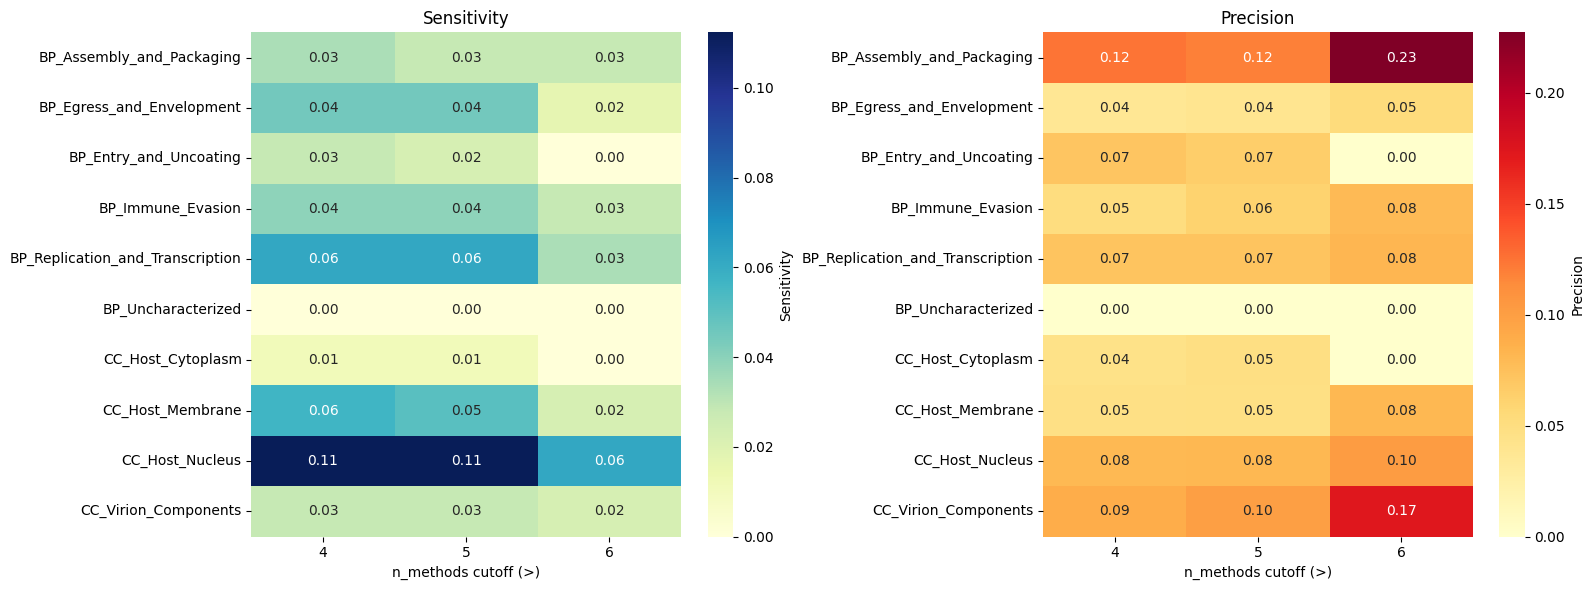

In [87]:
# heatmaps: rows = category, cols = threshold (cutoff)
import seaborn as sns
import matplotlib.pyplot as plt

# If multiple rows exist per (category, cutoff), use mean value
sens_mat = results_df.pivot_table(
    index='category',
    columns='cutoff',
    values='sensitivity',
    aggfunc='mean'
).sort_index()

prec_mat = results_df.pivot_table(
    index='category',
    columns='cutoff',
    values='precision',
    aggfunc='mean'
).sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, max(6, 0.5 * len(sens_mat))))

sns.heatmap(
    sens_mat,
    ax=axes[0],
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Sensitivity'}
)
axes[0].set_title('Sensitivity')
axes[0].set_xlabel('n_methods cutoff (>)')
axes[0].set_ylabel('')

sns.heatmap(
    prec_mat,
    ax=axes[1],
    cmap='YlOrRd',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Precision'}
)
axes[1].set_title('Precision')
axes[1].set_xlabel('n_methods cutoff (>)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# plt.savefig(os.path.join(plot_dir, "sensitivity_precision_kegg_enrichment.pdf"), format="pdf")
# plt.close()


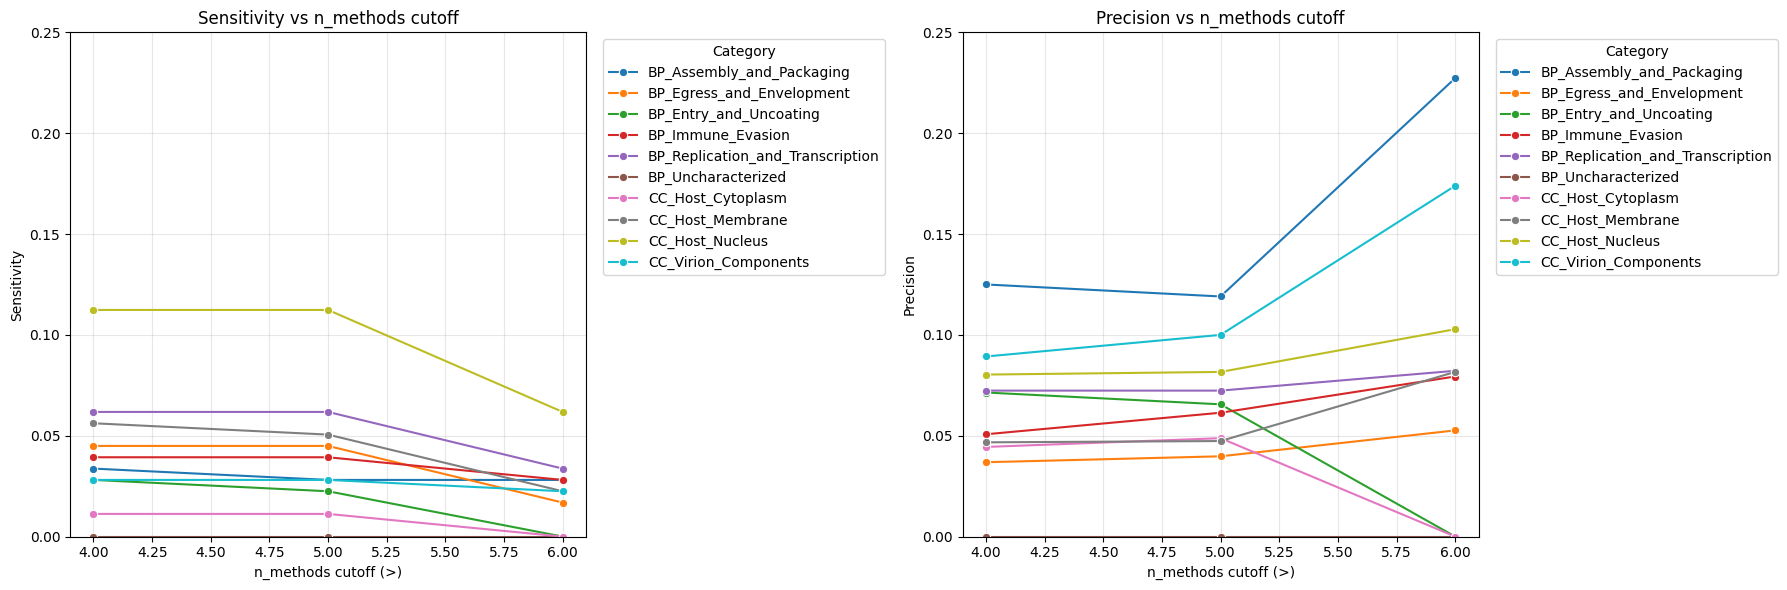

In [88]:
# line plots: metric trends across threshold for each category
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = results_df.copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

sns.lineplot(
    data=plot_df,
    x='cutoff',
    y='sensitivity',
    hue='category',
    marker='o',
    ax=axes[0]
)
axes[0].set_title('Sensitivity vs n_methods cutoff')
axes[0].set_xlabel('n_methods cutoff (>)')
axes[0].set_ylabel('Sensitivity')
axes[0].set_ylim(0, 0.25)
axes[0].grid(True, alpha=0.3)
axes[0].legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left')

sns.lineplot(
    data=plot_df,
    x='cutoff',
    y='precision',
    hue='category',
    marker='o',
    ax=axes[1]
)
axes[1].set_title('Precision vs n_methods cutoff')
axes[1].set_xlabel('n_methods cutoff (>)')
axes[1].set_ylabel('Precision')
axes[1].set_ylim(0, 0.25)
axes[1].grid(True, alpha=0.3)
axes[1].legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


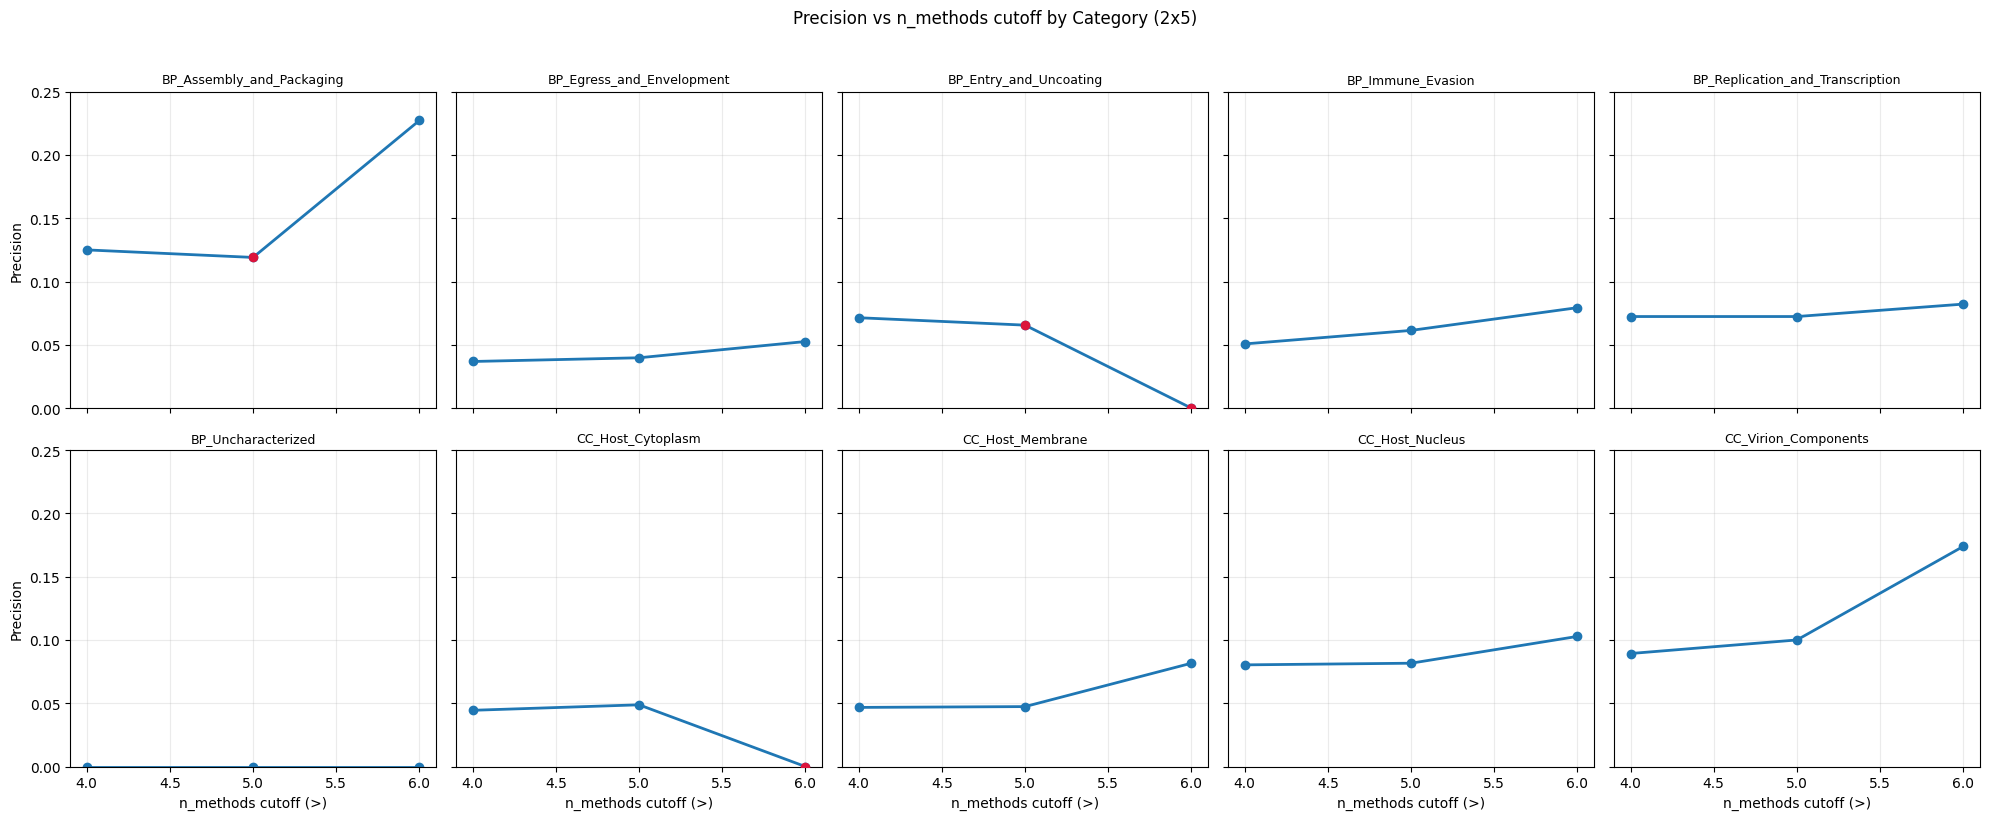

In [89]:
# precision vs threshold as subplots (2 rows x 5 columns)
import numpy as np
import matplotlib.pyplot as plt

agg = (results_df
       .groupby(['category', 'cutoff'], as_index=False)[['precision']]
       .mean()
       .sort_values(['category', 'cutoff']))

categories = sorted(agg['category'].unique())

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

if len(categories) > 10:
    print(f'Warning: {len(categories)} categories found; showing first 10.')

for i in range(10):
    ax = axes[i]
    if i >= len(categories):
        ax.axis('off')
        continue

    cat = categories[i]
    sub = agg[agg['category'] == cat].sort_values('cutoff')
    x = sub['cutoff'].to_numpy()
    y = sub['precision'].to_numpy()

    ax.plot(x, y, marker='o', lw=2, color='#1f77b4')

    # highlight drop points (precision decreases)
    drops = np.where(np.diff(y) < 0)[0]
    if len(drops) > 0:
        ax.scatter(x[drops + 1], y[drops + 1], color='crimson', s=35, zorder=4)

    ax.set_title(cat, fontsize=9)
    ax.set_ylim(0, 0.25)
    ax.grid(True, alpha=0.25)

# shared labels
for ax in axes[5:]:
    ax.set_xlabel('n_methods cutoff (>)')
for ax in axes[::5]:
    ax.set_ylabel('Precision')

fig.suptitle('Precision vs n_methods cutoff by Category (2x5)', y=1.02)
plt.tight_layout()
plt.show()


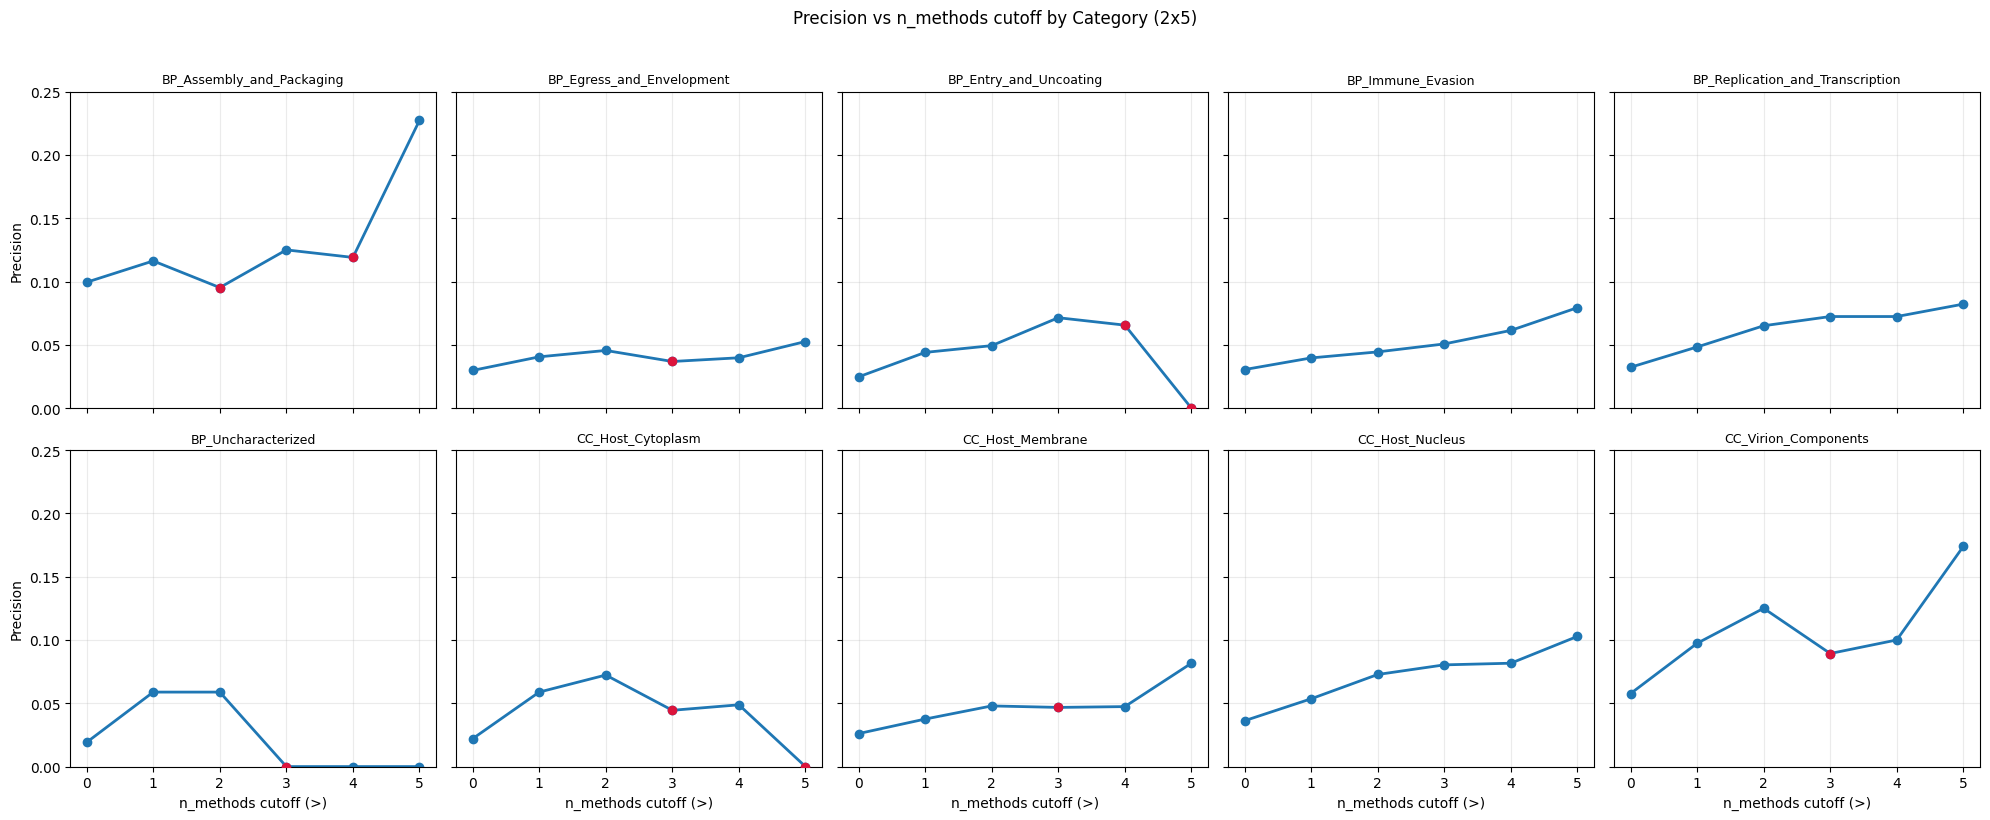

In [35]:
# precision vs threshold as subplots (2 rows x 5 columns)
import numpy as np
import matplotlib.pyplot as plt

agg = (results_df
       .groupby(['category', 'cutoff'], as_index=False)[['precision']]
       .mean()
       .sort_values(['category', 'cutoff']))

categories = sorted(agg['category'].unique())

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

if len(categories) > 10:
    print(f'Warning: {len(categories)} categories found; showing first 10.')

for i in range(10):
    ax = axes[i]
    if i >= len(categories):
        ax.axis('off')
        continue

    cat = categories[i]
    sub = agg[agg['category'] == cat].sort_values('cutoff')
    x = sub['cutoff'].to_numpy()
    y = sub['precision'].to_numpy()

    ax.plot(x, y, marker='o', lw=2, color='#1f77b4')

    # highlight drop points (precision decreases)
    drops = np.where(np.diff(y) < 0)[0]
    if len(drops) > 0:
        ax.scatter(x[drops + 1], y[drops + 1], color='crimson', s=35, zorder=4)

    ax.set_title(cat, fontsize=9)
    ax.set_ylim(0, 0.25)
    ax.grid(True, alpha=0.25)

# shared labels
for ax in axes[5:]:
    ax.set_xlabel('n_methods cutoff (>)')
for ax in axes[::5]:
    ax.set_ylabel('Precision')

fig.suptitle('Precision vs n_methods cutoff by Category (2x5)', y=1.02)
plt.tight_layout()
plt.show()



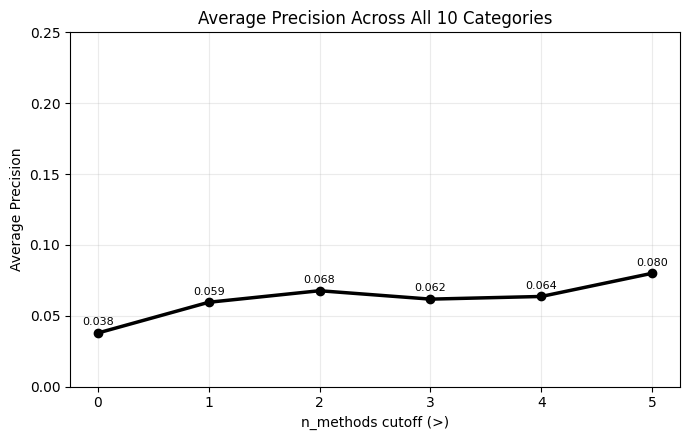

,cutoff,precision
0,0,0.037785
1,1,0.059493
2,2,0.067648
3,3,0.061717
4,4,0.063598
5,5,0.079981


In [36]:
# average precision across all categories (one curve)
import matplotlib.pyplot as plt

avg_df = (results_df
          .groupby('cutoff', as_index=False)['precision']
          .mean()
          .sort_values('cutoff'))

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(avg_df['cutoff'], avg_df['precision'], marker='o', lw=2.5, color='black')

for _, r in avg_df.iterrows():
    ax.text(r['cutoff'], r['precision'] + 0.004, f"{r['precision']:.3f}", ha='center', va='bottom', fontsize=8)

ax.set_title('Average Precision Across All 10 Categories')
ax.set_xlabel('n_methods cutoff (>)')
ax.set_ylabel('Average Precision')
ax.set_ylim(0, 0.25)
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

avg_df


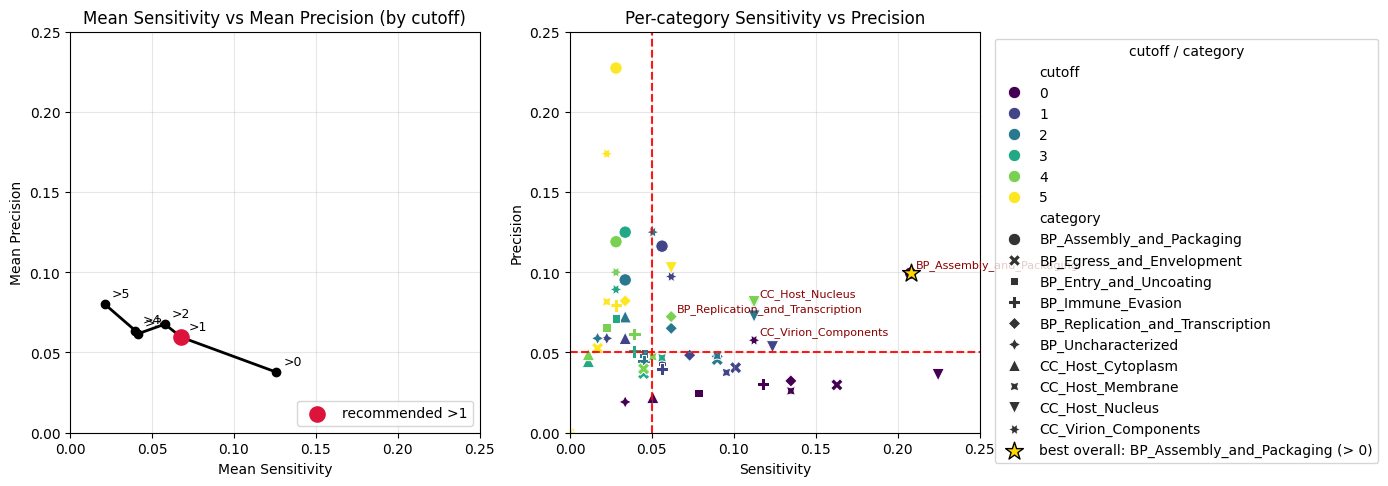

Recommended threshold by max mean F1: n_methods > 1
Categories with one selected best point (sensitivity>0.05 & precision>0.05): ['BP_Assembly_and_Packaging', 'BP_Replication_and_Transcription', 'CC_Host_Nucleus', 'CC_Virion_Components']
Best overall point: category=BP_Assembly_and_Packaging, cutoff>0, sensitivity=0.208, precision=0.099, f1=0.135


,cutoff,sensitivity_mean,sensitivity_std,precision_mean,precision_std,f1_mean
0,0,0.125843,0.062064,0.037785,0.024155,0.058119
1,1,0.067978,0.031049,0.059493,0.026439,0.063453
2,2,0.057865,0.030317,0.067648,0.025671,0.062375
3,3,0.041573,0.031133,0.061717,0.033976,0.049681
4,4,0.039888,0.031386,0.063598,0.033174,0.049026
5,5,0.021348,0.019061,0.079981,0.075267,0.033701


In [37]:
# sensitivity vs precision to choose threshold
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = results_df.copy()

# Aggregate across categories per cutoff (mean + variability)
summary = (plot_df
           .groupby('cutoff', as_index=False)
           .agg(sensitivity_mean=('sensitivity', 'mean'),
                sensitivity_std=('sensitivity', 'std'),
                precision_mean=('precision', 'mean'),
                precision_std=('precision', 'std'))
           .sort_values('cutoff'))

# F1 on aggregated means (harmonic mean)
summary['f1_mean'] = 2 * summary['precision_mean'] * summary['sensitivity_mean'] / (
    summary['precision_mean'] + summary['sensitivity_mean'] + 1e-12
)

# One recommendation rule: maximize mean F1
best_row = summary.loc[summary['f1_mean'].idxmax()]
recommended_cutoff = int(best_row['cutoff'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (A) mean tradeoff path by threshold
axes[0].plot(summary['sensitivity_mean'], summary['precision_mean'], '-o', color='black', lw=2)
for _, r in summary.iterrows():
    axes[0].annotate(f">{int(r['cutoff'])}", (r['sensitivity_mean'], r['precision_mean']),
                     textcoords='offset points', xytext=(5, 5), fontsize=9)

# highlight recommended threshold
axes[0].scatter(best_row['sensitivity_mean'], best_row['precision_mean'],
                s=120, color='crimson', zorder=4, label=f"recommended >{recommended_cutoff}")

axes[0].set_title('Mean Sensitivity vs Mean Precision (by cutoff)')
axes[0].set_xlabel('Mean Sensitivity')
axes[0].set_ylabel('Mean Precision')
axes[0].set_xlim(0, 0.25)
axes[0].set_ylim(0, 0.25)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='lower right')

# (B) per-category points: color by cutoff, symbol by category
sns.scatterplot(
    data=plot_df,
    x='sensitivity',
    y='precision',
    hue='cutoff',
    style='category',
    palette='viridis',
    s=80,
    ax=axes[1]
)
axes[1].set_title('Per-category Sensitivity vs Precision')

# annotate one best point per category (among points with both sensitivity and precision > 0.05)
cand = plot_df[(plot_df['sensitivity'] > 0.05) & (plot_df['precision'] > 0.05)].copy()
cand['f1'] = 2 * cand['precision'] * cand['sensitivity'] / (cand['precision'] + cand['sensitivity'] + 1e-12)

if not cand.empty:
    # one row per category: best by F1
    best_per_cat = (cand.sort_values('f1', ascending=False)
                    .groupby('category', as_index=False)
                    .first())

    for _, r in best_per_cat.iterrows():
        axes[1].annotate(str(r['category']), (r['sensitivity'], r['precision']),
                         textcoords='offset points', xytext=(4, 4), fontsize=8, color='darkred')

    # single overall best across categories
    best_overall = best_per_cat.loc[best_per_cat['f1'].idxmax()]
    axes[1].scatter(best_overall['sensitivity'], best_overall['precision'],
                    s=180, marker='*', color='gold', edgecolor='black', zorder=6,
                    label=f"best overall: {best_overall['category']} (> {int(best_overall['cutoff'])})")
    high_categories = sorted(best_per_cat['category'].unique().tolist())
else:
    best_per_cat = pd.DataFrame(columns=plot_df.columns.tolist() + ['f1'])
    best_overall = None
    high_categories = []
axes[1].set_xlabel('Sensitivity')
axes[1].set_ylabel('Precision')
axes[1].set_xlim(0, 0.25)
axes[1].set_ylim(0, 0.25)
axes[1].axvline(0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.9)
axes[1].axhline(0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.9)
axes[1].grid(True, alpha=0.3)
axes[1].legend(title='cutoff / category', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

print(f"Recommended threshold by max mean F1: n_methods > {recommended_cutoff}")
print('Categories with one selected best point (sensitivity>0.05 & precision>0.05):', high_categories)
if best_overall is not None:
    print(f"Best overall point: category={best_overall['category']}, cutoff>{int(best_overall['cutoff'])}, sensitivity={best_overall['sensitivity']:.3f}, precision={best_overall['precision']:.3f}, f1={best_overall['f1']:.3f}")
summary
